In [ ]:
!pip install pytorch-fid

In [ ]:
!pip install --force-reinstall scipy==1.11.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 46.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5


In [ ]:
import scipy

print(scipy.__version__)

1.11.1


# Gan

In [ ]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Layer 1
        self.layer1 = nn.Sequential(
            nn.Linear(64, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True)
        )

        # Layer 2
        self.layer2 = nn.Sequential(
            nn.Linear(512, 7 * 7 * 64),
            nn.BatchNorm1d(7 * 7 * 64),
            nn.ReLU(inplace=True)
        )
        self.unflatt=nn.Unflatten(1, (-1, 7, 7))
        # Layer 3 (PixelShuffle)
        self.pixel_shuffle1 = nn.PixelShuffle(2)

        # Layer 4
        self.layer4 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        # Layer 5 (PixelShuffle)
        self.pixel_shuffle2 = nn.PixelShuffle(2)

        # Layer 6
        self.layer6 = nn.Conv2d(8, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # Reshape input
        x = self.layer1(x)

        # Layer 2
        x = self.layer2(x)
        x =self.unflatt(x)

        # Layer 3 (PixelShuffle)
        x = self.pixel_shuffle1(x)

        # Layer 4
        x = self.layer4(x)

        # Layer 5 (PixelShuffle)
        x = self.pixel_shuffle2(x)

        # Layer 6
        x = self.layer6(x)

        return x

# Create an instance of the generator
generator = Generator()

# Print the architecture
print(generator)


Generator(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=512, out_features=3136, bias=True)
    (1): BatchNorm1d(3136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (unflatt): Unflatten(dim=1, unflattened_size=(-1, 7, 7))
  (pixel_shuffle1): PixelShuffle(upscale_factor=2)
  (layer4): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pixel_shuffle2): PixelShuffle(upscale_factor=2)
  (layer6): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [ ]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )

        # Layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )

        # Layer 3
        self.layer3 = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(inplace=True)
        )

        # Layer 4
        self.layer4 = nn.Linear(512, 1)

    def forward(self, x):
        # Layer 1
        x = self.layer1(x)

        # Layer 2
        x = self.layer2(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Layer 3
        x = self.layer3(x)

        # Layer 4
        x = self.layer4(x)

        return x

# Create an instance of the discriminator
discriminator = Discriminator()

# Print the architecture
print(discriminator)


Discriminator(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (layer3): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU(inplace=True)
  )
  (layer4): Linear(in_features=512, out_features=1, bias=True)
)


In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets

# Define batch_size
batch_size = 64

# Define the transformation
transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Create MNIST dataset
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create DataLoader
data_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 109623243.27it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21512288.02it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 33929703.17it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5178181.24it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0/50 completed. Average D_loss: 0.4360688478313709, Average G_loss: 2.561154230742026


Epoch 1/50 completed. Average D_loss: 0.3961481882557362, Average G_loss: 2.8068941162942824


Epoch 2/50 completed. Average D_loss: 0.37341995264400046, Average G_loss: 2.952563935481727


Epoch 3/50 completed. Average D_loss: 0.354070145702203, Average G_loss: 3.1225870349672813


Epoch 4/50 completed. Average D_loss: 0.32982852157547393, Average G_loss: 3.273261127346106


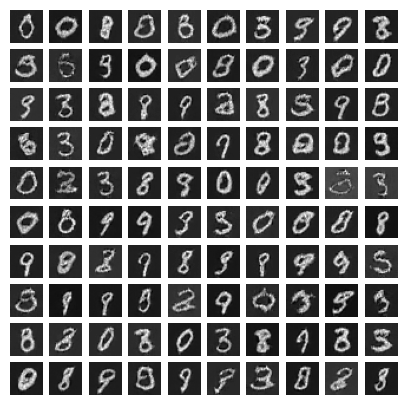

Epoch 5/50 completed. Average D_loss: 0.3121405356167685, Average G_loss: 3.3970300711548407


Epoch 6/50 completed. Average D_loss: 0.3135407897359533, Average G_loss: 3.482211574244855


Epoch 7/50 completed. Average D_loss: 0.3147252376482294, Average G_loss: 3.48022088030381


Epoch 8/50 completed. Average D_loss: 0.3028524969725858, Average G_loss: 3.6005524797226065


Epoch 9/50 completed. Average D_loss: 0.32097418106193387, Average G_loss: 3.5959163665263127


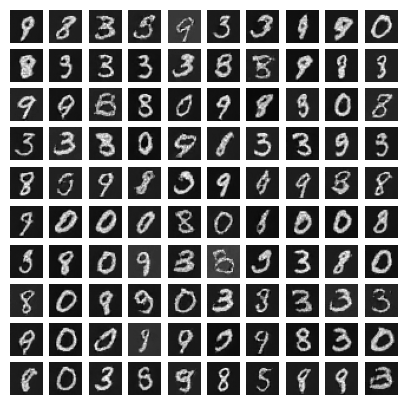

Epoch 10/50 completed. Average D_loss: 0.30529834901764324, Average G_loss: 3.646367666722615


Epoch 11/50 completed. Average D_loss: 0.300004575512437, Average G_loss: 3.7344521492529017


Epoch 12/50 completed. Average D_loss: 0.3064822455286545, Average G_loss: 3.6990442745594074


Epoch 13/50 completed. Average D_loss: 0.29545665671527666, Average G_loss: 3.7752314433614327


Epoch 14/50 completed. Average D_loss: 0.2908152719280858, Average G_loss: 3.8248450415475026


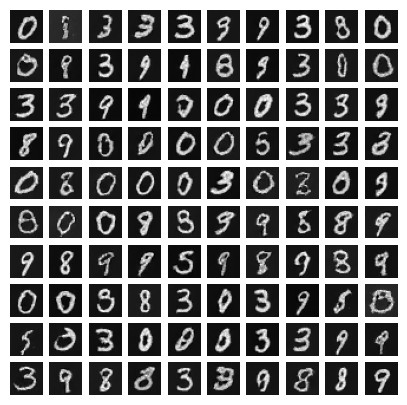

Epoch 15/50 completed. Average D_loss: 0.2835258249950998, Average G_loss: 3.8789748555815806


Epoch 16/50 completed. Average D_loss: 0.28284767886270273, Average G_loss: 3.9115657594158195


Epoch 17/50 completed. Average D_loss: 0.29586310365370344, Average G_loss: 3.8733951250500263


Epoch 18/50 completed. Average D_loss: 0.2882533847930968, Average G_loss: 3.9018716884574403


Epoch 19/50 completed. Average D_loss: 0.2877162382708364, Average G_loss: 3.881523199045836


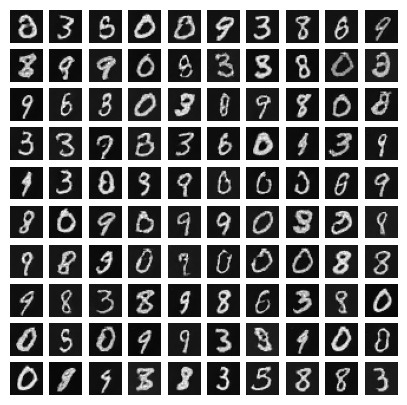

Epoch 20/50 completed. Average D_loss: 0.28290238587902106, Average G_loss: 3.9299939373917163


Epoch 21/50 completed. Average D_loss: 0.29208292297883404, Average G_loss: 3.9105801812367145


Epoch 22/50 completed. Average D_loss: 0.28200981172118417, Average G_loss: 3.9671277518211396


Epoch 23/50 completed. Average D_loss: 0.2801425865591208, Average G_loss: 3.9774962483184426


Epoch 24/50 completed. Average D_loss: 0.28025239364513116, Average G_loss: 3.9451896029748896


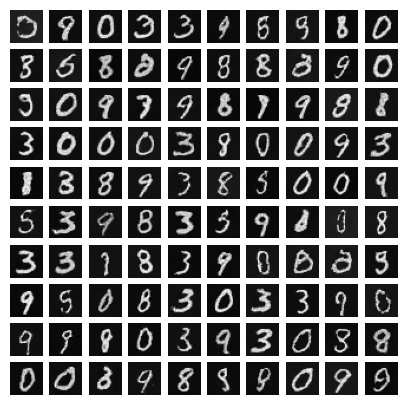

Epoch 25/50 completed. Average D_loss: 0.2834815348305904, Average G_loss: 3.9480455262320384


Epoch 26/50 completed. Average D_loss: 0.2753838764062759, Average G_loss: 3.975714737926719


Epoch 27/50 completed. Average D_loss: 0.27500910191054045, Average G_loss: 4.000698963080897


Epoch 28/50 completed. Average D_loss: 0.27898257575519103, Average G_loss: 4.007663372483081


Epoch 29/50 completed. Average D_loss: 0.2750283216765679, Average G_loss: 4.041203658209681


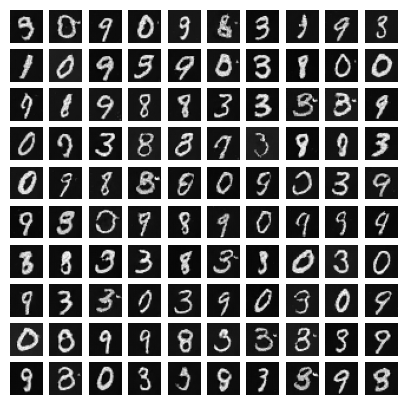

Epoch 30/50 completed. Average D_loss: 0.2702156841935618, Average G_loss: 4.039093404563506


Epoch 31/50 completed. Average D_loss: 0.2761644257077657, Average G_loss: 4.0094442148960985


Epoch 32/50 completed. Average D_loss: 0.2658917626791965, Average G_loss: 4.066351786351153


Epoch 33/50 completed. Average D_loss: 0.2655357606033844, Average G_loss: 4.078572645116208


Epoch 34/50 completed. Average D_loss: 0.26732719975110614, Average G_loss: 4.054490114452997


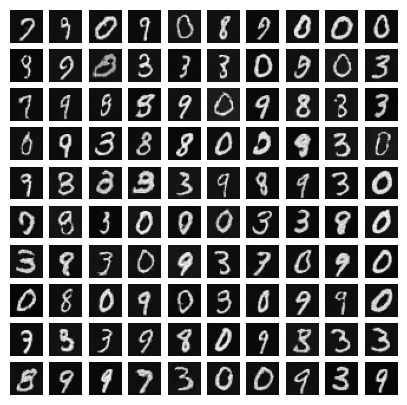

Epoch 35/50 completed. Average D_loss: 0.26600875571342325, Average G_loss: 4.043574719032499


Epoch 36/50 completed. Average D_loss: 0.2654565290611452, Average G_loss: 4.086120370481568


Epoch 37/50 completed. Average D_loss: 0.26315921228448513, Average G_loss: 4.0964509772339355


Epoch 38/50 completed. Average D_loss: 0.2609973499200928, Average G_loss: 4.128556525338688


Epoch 39/50 completed. Average D_loss: 0.26456784499265046, Average G_loss: 4.1282794414552795


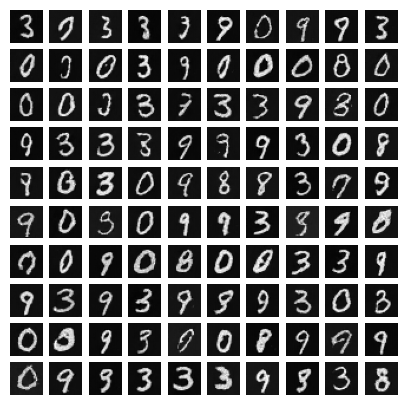

Epoch 40/50 completed. Average D_loss: 0.25994386327371544, Average G_loss: 4.1344629501991434


Epoch 41/50 completed. Average D_loss: 0.2609194665293354, Average G_loss: 4.116575733430858


Epoch 42/50 completed. Average D_loss: 0.25971222637213276, Average G_loss: 4.136834245627877


Epoch 43/50 completed. Average D_loss: 0.2520834277016617, Average G_loss: 4.157503599297009


Epoch 44/50 completed. Average D_loss: 0.2549917625952393, Average G_loss: 4.191721236400767


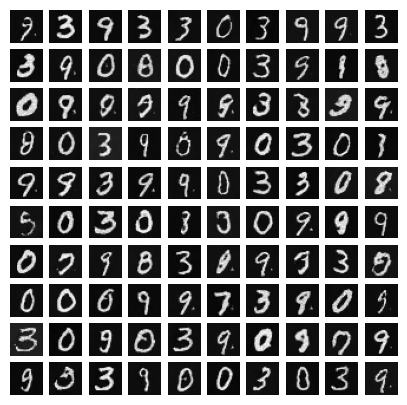

Epoch 45/50 completed. Average D_loss: 0.24408273060254054, Average G_loss: 4.2389340456614875


Epoch 46/50 completed. Average D_loss: 0.24968662306910622, Average G_loss: 4.23321323354107


Epoch 47/50 completed. Average D_loss: 0.2454722259811231, Average G_loss: 4.253701331773038


Epoch 48/50 completed. Average D_loss: 0.24369269749596476, Average G_loss: 4.259392029568076


Epoch 49/50 completed. Average D_loss: 0.238437504426185, Average G_loss: 4.302481293678284


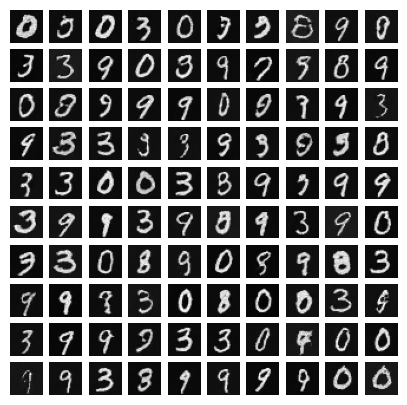

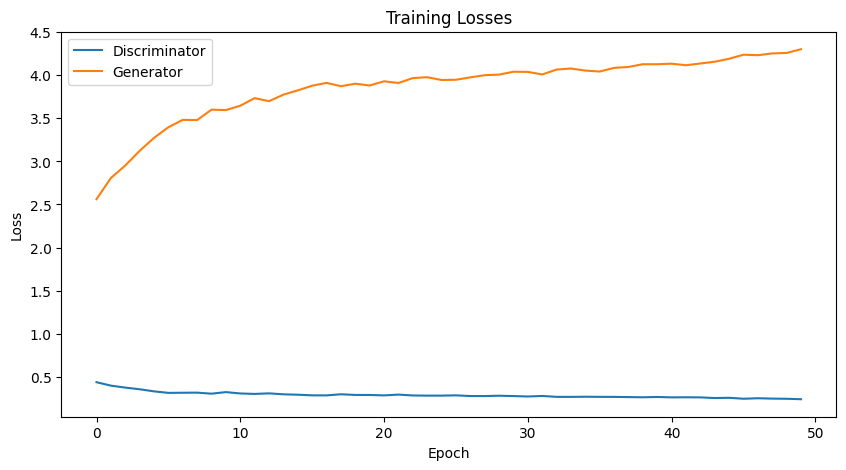

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from torchvision.utils import save_image
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




generator.to(device)
discriminator.to(device)

# Other parameters
latent_dim = 64
image_size = 28 * 28
batch_size = 64
epochs = 100
lr = 0.0002


# Loss function and optimizers
criterion = nn.BCEWithLogitsLoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# DataLoader setup
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Lists to store losses
losses_D = []
losses_G = []
# Training loop
epochs=50
log_interval=5
for epoch in range(epochs):
    epoch_loss_D = 0.0
    epoch_loss_G = 0.0

    tqdm_iterator = tqdm(data_loader, leave=False, desc=f'Epoch {epoch}/{epochs}')

    for i, (real_images, _) in enumerate(tqdm_iterator):
        batch_size = real_images.size(0)

        # Move real images to GPU
        real_images = real_images.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        real_outputs = discriminator(real_images)
        loss_D_real = criterion(real_outputs, real_labels)
        loss_D_real.backward()

        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(noise)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        fake_outputs = discriminator(fake_images.detach())
        loss_D_fake = criterion(fake_outputs, fake_labels)
        loss_D_fake.backward()

        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        generated_images = generator(noise)
        outputs_G = discriminator(generated_images)
        labels_G = torch.ones(batch_size, 1).to(device)
        loss_G = criterion(outputs_G, labels_G)
        loss_G.backward()
        optimizer_G.step()

        # Save losses per iteration
        epoch_loss_D += (loss_D_real.item() + loss_D_fake.item())
        epoch_loss_G += loss_G.item()

        # Update tqdm description with the current loss
        tqdm_iterator.set_postfix(D_loss=epoch_loss_D / (i + 1), G_loss=epoch_loss_G / (i + 1))

    # Average losses over all batches in the epoch
    avg_loss_D = epoch_loss_D / len(data_loader)
    avg_loss_G = epoch_loss_G / len(data_loader)

    # Save averaged losses
    losses_D.append(avg_loss_D)
    losses_G.append(avg_loss_G)
    print(f"Epoch {epoch}/{epochs} completed. Average D_loss: {avg_loss_D}, Average G_loss: {avg_loss_G}")
    if (epoch + 1) % log_interval == 0:
      with torch.no_grad():
          random_samples = generator(torch.randn(100, latent_dim).to(device))
          fig, axes = plt.subplots(10, 10, figsize=(5, 5))

          # Flatten the axes array
          axes = axes.flatten()
          random_samples = random_samples.view(100, 28, 28)

          # Loop through the images and plot them in the grid
          for i in range(100):
              ax = axes[i]
              ax.imshow(random_samples[i].cpu().numpy(), cmap='gray')
              ax.axis('off')  # Turn off axis labels
              ax.set_xticklabels([])
              ax.set_yticklabels([])

          plt.show()
    # Save generated images after each epoch
    with torch.no_grad():
        fake_samples = generator(torch.randn(16, latent_dim).to(device))
        save_image(fake_samples.view(16, 1, 28, 28).cpu(), f'gan_generated_epoch_{epoch + 1}.png')

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(losses_D, label='Discriminator')
plt.plot(losses_G, label='Generator')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
!rm -r "real_images"
!rm -r "generated_images"

rm: cannot remove 'real_images': No such file or directory
rm: cannot remove 'generated_images': No such file or directory


In [ ]:
from pytorch_fid import fid_score
import torchvision
import os


generated_images_path="generated_images"
real_images_path="real_images"
os.makedirs(generated_images_path, exist_ok=True)
os.makedirs(real_images_path, exist_ok=True)

with torch.no_grad():
    random_samples = generator(torch.randn(128, latent_dim).to(device)).view(-1, 28, 28)


for i, sample in enumerate(random_samples):
    torchvision.utils.save_image(sample, f'{generated_images_path}/generated_image_{i + 1}.png')

real_images = []
num_real_images_to_save=128

real_images=[]
for lables,images in data_loader:
    real_images.extend(lables)
    if len(real_images) >= num_real_images_to_save:
        break

# Save the real images using torchvision.utils.save_image
for i, real_sample in enumerate(real_images[:num_real_images_to_save]):
    torchvision.utils.save_image(real_sample, f'{real_images_path}/real_image_{i + 1}.png')


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from pytorch_fid import fid_score
import torchvision
import os
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generated_images_path="generated_images"
real_images_path="real_images"
batch_size=32
fid=fid_score.calculate_fid_given_paths([real_images_path, generated_images_path], batch_size=batch_size, device=device, dims=2048)
print(f"The Fid score is: {fid}")

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 196MB/s]
100%|██████████| 4/4 [00:00<00:00,  6.02it/s]


The Fid score is: 65.79289246404491


# Wasserstein GAN

Epoch 1/50: 100%|██████████| 938/938 [00:30<00:00, 31.10it/s]


Epoch [1/50], d_loss: -0.11585369782705011, g_loss: -0.04828818184710833


Epoch 2/50: 100%|██████████| 938/938 [00:25<00:00, 36.73it/s]


Epoch [2/50], d_loss: -0.04233226815520573, g_loss: 0.025379423241836944


Epoch 3/50: 100%|██████████| 938/938 [00:25<00:00, 37.06it/s]


Epoch [3/50], d_loss: -0.02521140268767503, g_loss: -0.027373672168424377


Epoch 4/50: 100%|██████████| 938/938 [00:28<00:00, 32.69it/s]


Epoch [4/50], d_loss: -0.02037690269615827, g_loss: -0.06072851615165597


Epoch 5/50: 100%|██████████| 938/938 [00:26<00:00, 35.78it/s]


Epoch [5/50], d_loss: -0.016944644418654283, g_loss: -0.06964400121807503


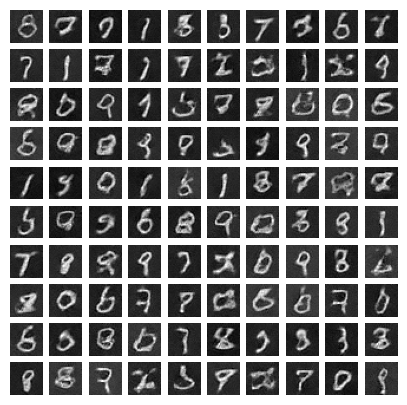

Epoch 6/50: 100%|██████████| 938/938 [00:25<00:00, 36.38it/s]


Epoch [6/50], d_loss: -0.014784334140069195, g_loss: -0.07298716037796794


Epoch 7/50: 100%|██████████| 938/938 [00:28<00:00, 32.76it/s]


Epoch [7/50], d_loss: -0.01296353229541959, g_loss: -0.07257612918902968


Epoch 8/50: 100%|██████████| 938/938 [00:25<00:00, 36.78it/s]


Epoch [8/50], d_loss: -0.011643561342461054, g_loss: -0.056639150973210345


Epoch 9/50: 100%|██████████| 938/938 [00:27<00:00, 34.51it/s]


Epoch [9/50], d_loss: -0.010723560746175363, g_loss: -0.05791209164497342


Epoch 10/50: 100%|██████████| 938/938 [00:27<00:00, 33.74it/s]


Epoch [10/50], d_loss: -0.009899279029954518, g_loss: -0.08308242481047494


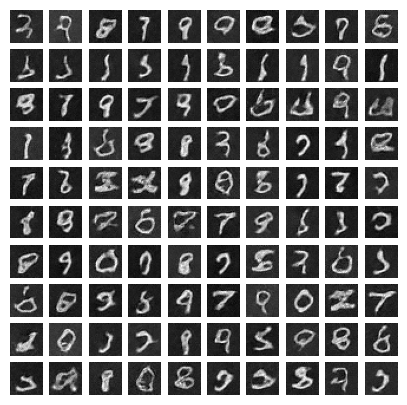

Epoch 11/50: 100%|██████████| 938/938 [00:25<00:00, 36.24it/s]


Epoch [11/50], d_loss: -0.009494885685108999, g_loss: -0.07178293959464632


Epoch 12/50: 100%|██████████| 938/938 [00:27<00:00, 33.56it/s]


Epoch [12/50], d_loss: -0.009308697502893298, g_loss: -0.07838912313627297


Epoch 13/50: 100%|██████████| 938/938 [00:23<00:00, 39.87it/s]


Epoch [13/50], d_loss: -0.008844540033465636, g_loss: -0.09246290940828601


Epoch 14/50: 100%|██████████| 938/938 [00:24<00:00, 38.79it/s]


Epoch [14/50], d_loss: -0.008328871543098217, g_loss: -0.0801308316070706


Epoch 15/50: 100%|██████████| 938/938 [00:26<00:00, 35.71it/s]


Epoch [15/50], d_loss: -0.007990421198342226, g_loss: -0.07494512633406875


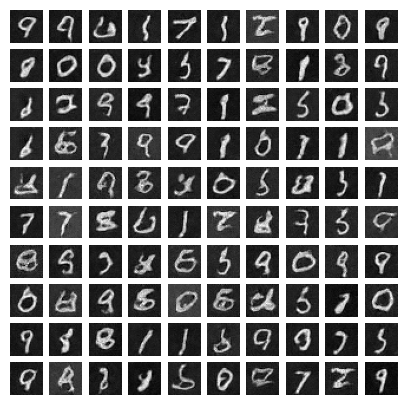

Epoch 16/50: 100%|██████████| 938/938 [00:24<00:00, 38.56it/s]


Epoch [16/50], d_loss: -0.007656633078968569, g_loss: -0.06206917887412584


Epoch 17/50: 100%|██████████| 938/938 [00:25<00:00, 37.00it/s]


Epoch [17/50], d_loss: -0.0070621358874345275, g_loss: -0.07188045978943296


Epoch 18/50: 100%|██████████| 938/938 [00:27<00:00, 34.66it/s]


Epoch [18/50], d_loss: -0.006735116259372636, g_loss: -0.06918664022931147


Epoch 19/50: 100%|██████████| 938/938 [00:24<00:00, 38.41it/s]


Epoch [19/50], d_loss: -0.0063521043215788945, g_loss: -0.05936682474603856


Epoch 20/50: 100%|██████████| 938/938 [00:24<00:00, 38.73it/s]


Epoch [20/50], d_loss: -0.006075849889892775, g_loss: -0.05195996108504488


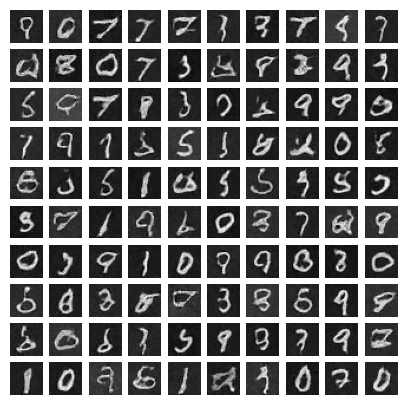

Epoch 21/50: 100%|██████████| 938/938 [00:27<00:00, 34.33it/s]


Epoch [21/50], d_loss: -0.005780641933027377, g_loss: -0.04964308716050016


Epoch 22/50: 100%|██████████| 938/938 [00:25<00:00, 36.74it/s]


Epoch [22/50], d_loss: -0.005601577555089553, g_loss: -0.05693378229231473


Epoch 23/50: 100%|██████████| 938/938 [00:24<00:00, 38.79it/s]


Epoch [23/50], d_loss: -0.0055017936176735595, g_loss: -0.038165623390234694


Epoch 24/50: 100%|██████████| 938/938 [00:28<00:00, 33.31it/s]


Epoch [24/50], d_loss: -0.0051108665654122, g_loss: -0.03978052455367201


Epoch 25/50: 100%|██████████| 938/938 [00:24<00:00, 38.59it/s]


Epoch [25/50], d_loss: -0.005015642702284612, g_loss: -0.03793740874118006


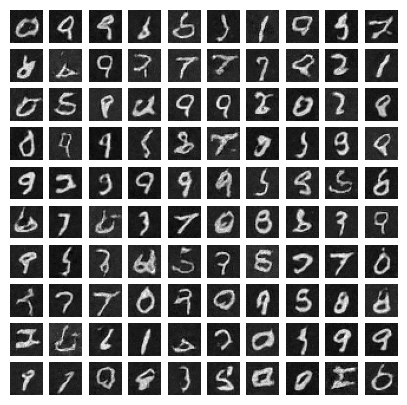

Epoch 26/50: 100%|██████████| 938/938 [00:24<00:00, 39.06it/s]


Epoch [26/50], d_loss: -0.004889421331545294, g_loss: -0.0395507935210499


Epoch 27/50: 100%|██████████| 938/938 [00:27<00:00, 33.94it/s]


Epoch [27/50], d_loss: -0.004546018465529325, g_loss: -0.02980428989289074


Epoch 28/50: 100%|██████████| 938/938 [00:24<00:00, 37.69it/s]


Epoch [28/50], d_loss: -0.004333644577645576, g_loss: -0.02983398485275272


Epoch 29/50: 100%|██████████| 938/938 [00:24<00:00, 37.96it/s]


Epoch [29/50], d_loss: -0.0042044614694381095, g_loss: -0.022978830129656975


Epoch 30/50: 100%|██████████| 938/938 [00:26<00:00, 34.75it/s]


Epoch [30/50], d_loss: -0.00399055225818829, g_loss: -0.02259971356934504


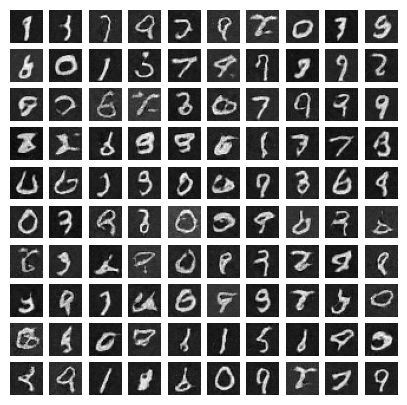

Epoch 31/50: 100%|██████████| 938/938 [00:24<00:00, 38.18it/s]


Epoch [31/50], d_loss: -0.003800754346807839, g_loss: -0.018945564973948233


Epoch 32/50: 100%|██████████| 938/938 [00:26<00:00, 35.26it/s]


Epoch [32/50], d_loss: -0.0037389774347589945, g_loss: -0.016695319055118535


Epoch 33/50: 100%|██████████| 938/938 [00:26<00:00, 35.52it/s]


Epoch [33/50], d_loss: -0.003365922516816532, g_loss: -0.00886868691413295


Epoch 34/50: 100%|██████████| 938/938 [00:25<00:00, 36.69it/s]


Epoch [34/50], d_loss: -0.0033629400939094835, g_loss: -0.012415143683649424


Epoch 35/50: 100%|██████████| 938/938 [00:27<00:00, 34.27it/s]


Epoch [35/50], d_loss: -0.003440549162138047, g_loss: -0.01846379723185415


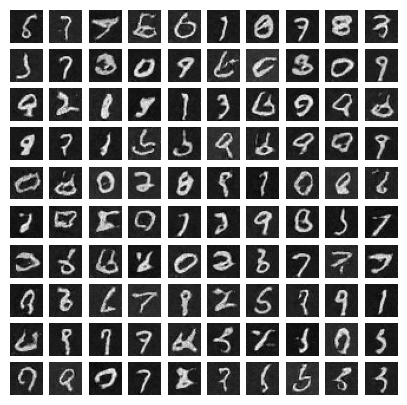

Epoch 36/50: 100%|██████████| 938/938 [00:25<00:00, 37.39it/s]


Epoch [36/50], d_loss: -0.003282853962927024, g_loss: -0.009129807890044339


Epoch 37/50: 100%|██████████| 938/938 [00:25<00:00, 37.07it/s]


Epoch [37/50], d_loss: -0.0031881386066413622, g_loss: -0.010061739856656616


Epoch 38/50: 100%|██████████| 938/938 [00:28<00:00, 33.10it/s]


Epoch [38/50], d_loss: -0.003007387394022975, g_loss: -0.008539719930593062


Epoch 39/50: 100%|██████████| 938/938 [00:24<00:00, 37.84it/s]


Epoch [39/50], d_loss: -0.0030571089671882017, g_loss: -0.007506125332219953


Epoch 40/50: 100%|██████████| 938/938 [00:26<00:00, 35.53it/s]


Epoch [40/50], d_loss: -0.003004309826226198, g_loss: -0.009172176504772015


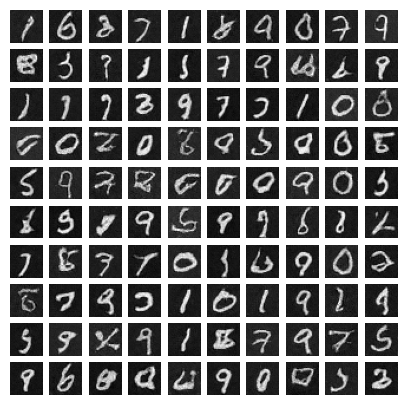

Epoch 41/50: 100%|██████████| 938/938 [00:29<00:00, 32.19it/s]


Epoch [41/50], d_loss: -0.0028335380202619983, g_loss: -0.009269939482603075


Epoch 42/50: 100%|██████████| 938/938 [00:25<00:00, 36.57it/s]


Epoch [42/50], d_loss: -0.002727660439736736, g_loss: -0.0064570536185993


Epoch 43/50: 100%|██████████| 938/938 [00:26<00:00, 34.82it/s]


Epoch [43/50], d_loss: -0.002686863639148703, g_loss: -0.005088009253124841


Epoch 44/50: 100%|██████████| 938/938 [00:27<00:00, 34.66it/s]


Epoch [44/50], d_loss: -0.002580777874518273, g_loss: -0.0019133009380715063


Epoch 45/50: 100%|██████████| 938/938 [00:25<00:00, 37.09it/s]


Epoch [45/50], d_loss: -0.0026737937702735796, g_loss: -0.004716778735524783


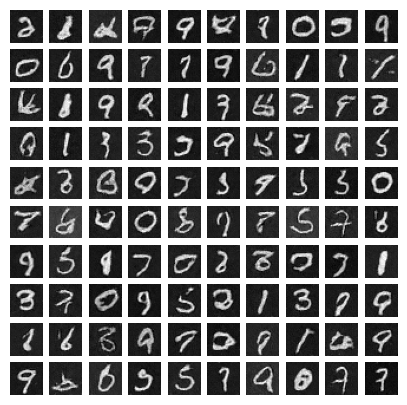

Epoch 46/50: 100%|██████████| 938/938 [00:29<00:00, 32.29it/s]


Epoch [46/50], d_loss: -0.002913961571870622, g_loss: 0.0006481725456490209


Epoch 47/50: 100%|██████████| 938/938 [00:25<00:00, 36.15it/s]


Epoch [47/50], d_loss: -0.0032148826940566985, g_loss: 0.005273711588041338


Epoch 48/50: 100%|██████████| 938/938 [00:25<00:00, 37.25it/s]


Epoch [48/50], d_loss: -0.003277528764884065, g_loss: 0.004308438167640089


Epoch 49/50: 100%|██████████| 938/938 [00:28<00:00, 32.46it/s]


Epoch [49/50], d_loss: -0.003311836228111207, g_loss: 0.004355594897625356


Epoch 50/50: 100%|██████████| 938/938 [00:25<00:00, 37.28it/s]


Epoch [50/50], d_loss: -0.003177485774149066, g_loss: 0.0032682535530455577


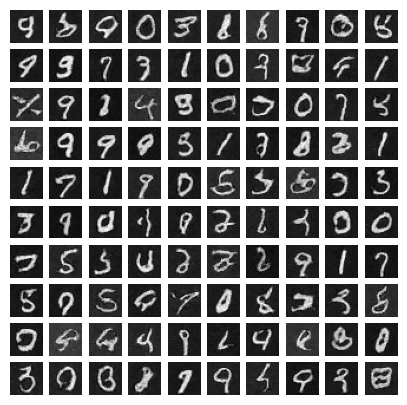

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from torchvision.utils import save_image
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Create an instance of the generator
generator = Generator()
# Create an instance of the discriminator
discriminator = Discriminator()

# Move models to GPU
generator.to(device)
discriminator.to(device)

# Other parameters
latent_dim = 64
image_size = 28 * 28
batch_size = 64
epochs = 50
lr = 0.0002

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizers
optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=lr)

# Transformations for MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
clip_value = 0.01
# Training loop
# Lists to store losses
d_losses = []
g_losses = []
log_interval=5

# Training loop
for epoch in range(epochs):
    d_loss_total = 0.0
    g_loss_total = 0.0

    for i, (real_images, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
        batch_size = real_images.size(0)

        # Train Discriminator
        real_images = real_images.to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(z)

        real_scores = discriminator(real_images)
        fake_scores = discriminator(fake_images.detach())

        d_loss = -torch.mean(real_scores) + torch.mean(fake_scores)
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Clip weights of the discriminator
        for param in discriminator.parameters():
            param.data.clamp_(-clip_value, clip_value)

        d_loss_total += d_loss.item()

        # Train Generator
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(z)
        fake_scores = discriminator(fake_images)

        g_loss = -torch.mean(fake_scores)
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()
        g_loss_total += g_loss.item()


    # Average losses over all batches in the epoch
    d_loss_avg = d_loss_total / len(train_loader)
    g_loss_avg = g_loss_total / len(train_loader)

    # Append losses to the lists
    d_losses.append(d_loss_avg)
    g_losses.append(g_loss_avg)

    # Print progress
    print(f"Epoch [{epoch+1}/{epochs}], d_loss: {d_loss_avg}, g_loss: {g_loss_avg}")

    if (epoch + 1) % log_interval == 0:
      with torch.no_grad():
          random_samples = generator(torch.randn(100, latent_dim).to(device))
          fig, axes = plt.subplots(10, 10, figsize=(5, 5))

          # Flatten the axes array
          axes = axes.flatten()
          random_samples = random_samples.view(100, 28, 28)

          # Loop through the images and plot them in the grid
          for i in range(100):
              ax = axes[i]
              ax.imshow(random_samples[i].cpu().numpy(), cmap='gray')
              ax.axis('off')  # Turn off axis labels
              ax.set_xticklabels([])
              ax.set_yticklabels([])

          plt.show()
    # Save generated images after each epoch
    with torch.no_grad():
        fake_samples = generator(torch.randn(16, latent_dim).to(device))
        save_image(fake_samples.view(16, 1, 28, 28).cpu(), f'Wgan_generated_epoch_{epoch + 1}.png')




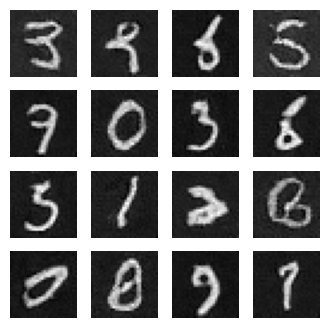

In [ ]:
# Generate some samples after training
generator.eval()
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    generated_images = generator(z).view(-1, 28, 28)

# Plot generated images
plt.figure(figsize=(4, 4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated_images[i].cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

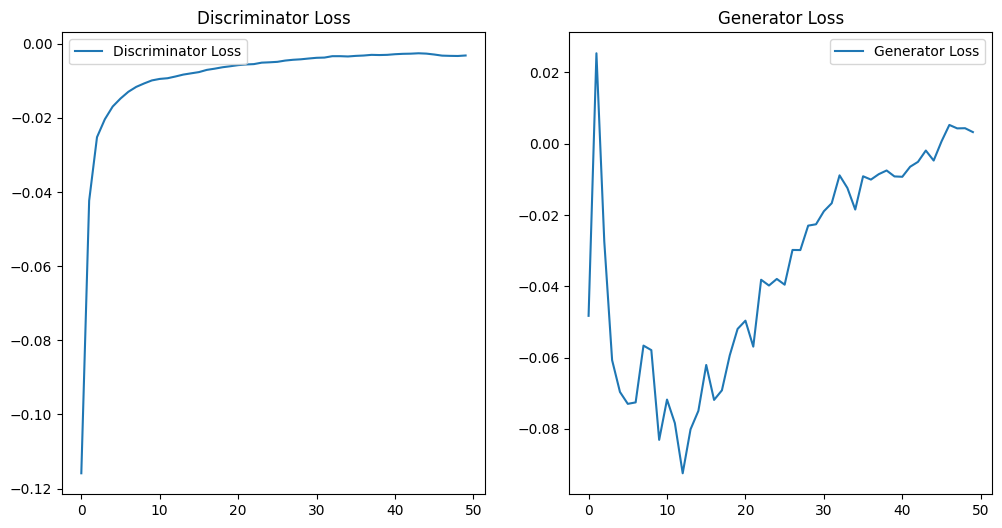

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(d_losses, label='Discriminator Loss')
plt.legend()
plt.title('Discriminator Loss')

plt.subplot(1, 2, 2)
plt.plot(g_losses, label='Generator Loss')
plt.legend()
plt.title('Generator Loss')

plt.show()

In [ ]:
!rm -r "generated_images"
!rm -r "real_images"

In [ ]:
from pytorch_fid import fid_score
import torchvision
import os


generated_images_path="generated_images"
real_images_path="real_images"
os.makedirs(generated_images_path, exist_ok=True)  # Create the directory if it doesn't exist
os.makedirs(real_images_path, exist_ok=True)  # Create the directory if it doesn't exist

with torch.no_grad():
    random_samples = generator(torch.randn(128, latent_dim).to(device))

for i, sample in enumerate(random_samples):
    torchvision.utils.save_image(sample, f'{generated_images_path}/generated_image_{i + 1}.png')

real_images = []
num_real_images_to_save=128

real_images=[]
for lables,images in data_loader:
    real_images.extend(lables)
    if len(real_images) >= num_real_images_to_save:
        break

# Save the real images using torchvision.utils.save_image
for i, real_sample in enumerate(real_images[:num_real_images_to_save]):
    torchvision.utils.save_image(real_sample, f'{real_images_path}/real_image_{i + 1}.png')

fid=fid_score.calculate_fid_given_paths([real_images_path, generated_images_path], batch_size=batch_size, device=device, dims=2048)
print(f"The Fid score is: {fid}")

100%|██████████| 4/4 [00:00<00:00,  6.53it/s]


The Fid score is: 62.320661755365705


# Self-Supervised GAN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpectralNorm:
    def __init__(self, name: str):
        self.name = name

    def compute_weight(self, module: nn.Module):
        weight = getattr(module, self.name + '_orig')
        u = getattr(module, self.name + '_u')
        size = weight.size()
        weight_mat = weight.view(size[0], -1)

        v = weight_mat.t() @ u
        v = v / (v.norm() + 1e-12)  # Adding epsilon for numerical stability
        u = weight_mat @ v
        u = u / (u.norm() + 1e-12)

        sigma = u.t() @ weight_mat @ v
        weight_sn = weight / sigma
        weight_sn = weight_sn.view(*size)

        return weight_sn, u

    @staticmethod
    def apply(module: nn.Module, name: str = 'weight'):
        fn = SpectralNorm(name)

        weight = getattr(module, name)
        setattr(module, name + '_orig', weight)
        module._parameters[name] = nn.Parameter(weight.data)

        u = torch.randn(weight.size(0), 1) * 0.1
        u = nn.Parameter(u, requires_grad=False)
        setattr(module, name + '_u', u)

        setattr(module, name, fn.compute_weight(module)[0])

        module.register_forward_pre_hook(fn)

        return fn

    def __call__(self, module: nn.Module, _: torch.Tensor):
        weight_sn, u = self.compute_weight(module)
        setattr(module, self.name, weight_sn)
        setattr(module, self.name + '_u', u)

def spectral_norm(module: nn.Module, name: str = 'weight') -> nn.Module:
    SpectralNorm.apply(module, name)
    return module


def log_sum_exp(x, axis = 1):
    m = torch.max(x, keepdim = True)
    return m + torch.logsumexp(x - m, dim = 1, keepdim = True)


class conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, padding, kernel_size = 4, stride = 2,
                spectral_normed = False):
        super(conv2d, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride,
                                padding = padding)
        if spectral_normed:
            self.conv = spectral_norm(self.conv)

    def forward(self, input):
        out = self.conv(input)
        return out


class deconv2d(nn.Module):
    def __init__(self, in_channels, out_channels, padding, kernel_size = (4,4), stride = (2,2),
                spectral_normed = False, iter = 1):
        super(deconv2d, self).__init__()

        self.devconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                        stride, padding = padding)
        if spectral_normed:
            self.devconv = spectral_norm(self.deconv)

    def forward(self, input):
        out = self.devconv(input)
        return out


def conv_cond_concat(x, y):
    x_shapes = list(x.size())
    y_shapes = list(y.size())
    return torch.cat((x,y*torch,ones(x_shapes[0],x_shapes[1],x_shapes[2],y_shapes[3])))


class Residual_G(nn.Module):
    def __init__(self, in_channels, out_channels = 256, kernel_size = 3, stride = 1,
                spectral_normed = False, up_sampling = False):
        super(Residual_G, self).__init__()
        self.up_sampling = up_sampling
        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm2d(in_channels)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.upsample = nn.Upsample(scale_factor = 2, mode = 'nearest')
        self.conv1 = conv2d(in_channels, out_channels, spectral_normed = spectral_normed,
                            kernel_size = kernel_size, stride = stride, padding = 1)
        self.conv2 = conv2d(out_channels, out_channels, spectral_normed= spectral_normed,
                            kernel_size = kernel_size, stride = stride, padding = 1)

    def forward(self, x):
        input = x
        x = self.relu(self.batch_norm1(x))
        if self.up_sampling:
            x = self.upsample(x)
        x = self.conv1(x)
        x = self.batch_norm2(x)
        x = self.conv2(self.relu(x))
        if self.up_sampling:
            return self.upsample(input) + x
        else:
            return input + x


class Residual_D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel = 3, stride = 1,
                spectral_normed = False, down_sampling = False, is_start = False):
        super(Residual_D, self).__init__()
        self.down_sampling = down_sampling
        self.is_start = is_start

        self.avgpool_short = nn.AvgPool2d(2, 2, padding = 1)
        self.conv_short = conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0,
                                spectral_normed = False)
        self.conv1 = conv2d(in_channels, out_channels, spectral_normed = spectral_normed,
                            kernel_size = kernel, stride = stride, padding = 1)
        self.conv2 = conv2d(out_channels, out_channels, spectral_normed = spectral_normed,
                            kernel_size = kernel, stride = stride, padding = 1)
        self.avgpool2 = nn.AvgPool2d(2, 2, padding = 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        input = x
        if self.is_start:
            conv1 = self.relu(self.conv1(x))
            conv2 = self.relu(self.conv2(conv1))
            if self.down_sampling:
                conv2 = self.avgpool2(conv2)
        else:
            conv1 = self.conv1(self.relu(x))
            conv2 = self.conv2(self.relu(conv1))
            if self.down_sampling:
                conv2 = self.avgpool2(conv2)

        if self.down_sampling:
            input = self.avgpool_short(input)
        resi = self.conv_short(input)

        return resi + conv2


In [2]:

import os.path
import tarfile, sys, math
import numpy as np
import scipy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import make_grid
from torch.autograd import grad as torch_grad


class Discriminator(nn.Module):
    def __init__(self, spectral_normed, num_rotation,
                ssup, channel, resnet = False):
        super(Discriminator, self).__init__()
        self.resnet = resnet
        self.num_rotation = num_rotation
        self.ssup = ssup

        self.lrelu = nn.LeakyReLU()
        self.relu = nn.ReLU()
        self.conv1 = conv2d(channel, 64, kernel_size = 3, stride = 1, padding = 1,
                            spectral_normed = spectral_normed)
        self.conv2 = conv2d(64, 128, spectral_normed = spectral_normed,
                            padding = 0)
        self.conv3 = conv2d(128, 256, spectral_normed = spectral_normed,
                            padding = 0)
        self.conv4 = conv2d(256, 512, spectral_normed = spectral_normed,
                            padding = 0)
        self.fully_connect_gan1 = nn.Linear(512, 1)
        self.fully_connect_rot1 = nn.Linear(512, 4)
        self.softmax = nn.Softmax()

        self.re1 = Residual_D(channel, 128, spectral_normed = spectral_normed,
                            down_sampling = True, is_start = True)
        self.re2 = Residual_D(128, 128, spectral_normed = spectral_normed,
                            down_sampling = True)
        self.re3 = Residual_D(128, 128, spectral_normed = spectral_normed)
        self.re4 = Residual_D(128, 128, spectral_normed = spectral_normed)
        self.fully_connect_gan2 = nn.Linear(128, 1)
        self.fully_connect_rot2 = nn.Linear(128, 4)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        if self.resnet == False:
            conv1 = self.lrelu(self.conv1(x))
            conv2 = self.lrelu(self.conv2(conv1))
            conv3 = self.lrelu(self.conv3(conv2))
            conv4 = self.lrelu(self.conv4(conv3))
            conv4 = torch.view(conv4.size(0)*self.num_rotation, -1)
            gan_logits = self.fully_connect_gan1(conv4)
            if self.ssup:
                rot_logits = self.fully_connect_rot1(conv4)
                rot_prob = self.softmax(rot_logits)
        else:
            re1 = self.re1(x)
            re2 = self.re2(re1)
            re3 = self.re3(re2)
            re4 = self.re4(re3)
            re4 = self.relu(re4)
            re4 = torch.sum(re4,dim = (2,3))
            gan_logits = self.fully_connect_gan2(re4)
            if self.ssup:
                rot_logits = self.fully_connect_rot2(re4)
                rot_prob = self.softmax(rot_logits)

        if self.ssup:
            return self.sigmoid(gan_logits), gan_logits, rot_logits, rot_prob
        else:
            return self.sigmoid(gan_logits), gan_logits



class Generator(nn.Module):
    def __init__(self, z_size, channel, resnet = False, output_size = 32):
        super(Generator, self).__init__()
        s = 4
        self.output_size = output_size
        if self.output_size == 32:
            s = 4
        if self.output_size == 48:
            s = 6
        self.s = s
        self.z_size = z_size
        self.resnet = resnet
        self.fully_connect = nn.Linear(z_size, s*s*256)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

        self.deconv1 = deconv2d(256, 256, padding = 0)
        self.bn1 = nn.BatchNorm2d(256)
        self.deconv2 = deconv2d(256, 128, padding = 0)
        self.bn2 = nn.BatchNorm2d(128)
        self.deconv3 = deconv2d(128, 64, padding = 0)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = conv2d(64, channel, padding = 1, kernel_size = 3, stride = 1)
        self.conv_res4 = conv2d(256,channel, padding = 1, kernel_size = 3, stride = 1)

        self.re1 = Residual_G(256, 256, up_sampling = True)
        self.re2 = Residual_G(256, 256, up_sampling = True)
        self.re3 = Residual_G(256, 256, up_sampling = True)
        self.bn = nn.BatchNorm2d(256)

    def forward(self, x):
        d1 = self.fully_connect(x)
        d1 = d1.view(-1, 256, self.s, self.s)
        if self.resnet == False:
            d1 = self.relu(d1)
            d2 = self.relu(self.bn1(self.deconv1(d1)))
            d3 = self.relu(self.bn2(self.deconv2(d2)))
            d4 = self.relu(self.bn3(self.deconv3(d3)))
            d5 = self.conv4(d4)
        else:
            d2 = self.re1(d1)
            d3 = self.re2(d2)
            d4 = self.re3(d3)
            d4 = self.relu(self.bn(d4))
            d5 = self.conv_res4(d4)

        return self.tanh(d5)

    def sample_latent(self, num_samples):
        return torch.randn((num_samples, self.z_size))


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.autograd import grad as torch_grad
from tqdm import tqdm
import matplotlib.pyplot as plt
import imageio
import numpy as np
from torch.autograd import Variable



class Trainer:
    def __init__(self, generator, discriminator, gen_optimizer, dis_optimizer,
                 weight_rotation_loss_d, weight_rotation_loss_g, gp_weight=10,
                 critic_iterations=5, print_every=50, use_cuda=False):
        self.device = torch.device('cuda' if use_cuda else 'cpu')
        self.G = generator.to(self.device)
        self.G_opt = gen_optimizer
        self.D = discriminator.to(self.device)
        self.D_opt = dis_optimizer
        self.losses = {'G': [], 'D': [], 'GP': [], 'gradient_norm': []}
        self.num_steps = 0
        self.gp_weight = gp_weight
        self.critic_iterations = critic_iterations
        self.print_every = print_every
        self.weight_rotation_loss_d = weight_rotation_loss_d
        self.weight_rotation_loss_g = weight_rotation_loss_g

        if self.use_cuda:
            self.G.cuda()
            self.D.cuda()

    def _critic_train_iteration(self, data, generated_data, batch_size):
        """ """
        # Calculate probabilities on real and generated data
        data = Variable(data)
        if self.use_cuda:
            data = data.cuda()
        _, d_real_pro_logits, d_real_rot_logits, d_real_rot_prob = self.D(data)
        _, g_fake_pro_logits, g_fake_rot_logits, g_fake_rot_prob = self.D(generated_data)

        # Get gradient penalty
        gradient_penalty = self._gradient_penalty(data, generated_data)
        self.losses['GP'].append(gradient_penalty.data)

        # Create total loss and optimize
        self.D_opt.zero_grad()
        d_loss = torch.sum(g_fake_pro_logits) - torch.sum(d_real_pro_logits) + gradient_penalty

        # Add auxiiary rotation loss
        rot_labels = torch.zeros(4*batch_size).cuda()
        for i in range(4*batch_size):
            if i < batch_size:
                rot_labels[i] = 0
            elif i < 2*batch_size:
                rot_labels[i] = 1
            elif i < 3*batch_size:
                rot_labels[i] = 2
            else:
                rot_labels[i] = 3

        rot_labels = F.one_hot(rot_labels.to(torch.int64), 4).float()
        d_real_class_loss = torch.sum(F.binary_cross_entropy_with_logits(
                                    input = d_real_rot_logits,
                                    target = rot_labels))

        d_loss += self.weight_rotation_loss_d * d_real_class_loss
        d_loss.backward(retain_graph=True)

        self.D_opt.step()

        # Record loss
        self.losses['D'].append(d_loss.data)

    def _generator_train_iteration(self, generated_data, batch_size):
        """ """
        self.G_opt.zero_grad()

        # Calculate loss and optimize
        _, g_fake_pro_logits, g_fake_rot_logits, g_fake_rot_prob = self.D(generated_data)
        g_loss = - torch.sum(g_fake_pro_logits)

        # add auxiliary rotation loss
        rot_labels = torch.zeros(4*batch_size,).cuda()
        for i in range(4*batch_size):
            if i < batch_size:
                rot_labels[i] = 0
            elif i < 2*batch_size:
                rot_labels[i] = 1
            elif i < 3*batch_size:
                rot_labels[i] = 2
            else:
                rot_labels[i] = 3

        rot_labels = F.one_hot(rot_labels.to(torch.int64), 4).float()
        g_fake_class_loss = torch.sum(F.binary_cross_entropy_with_logits(
            input = g_fake_rot_logits,
            target = rot_labels))


        g_loss += self.weight_rotation_loss_g * g_fake_class_loss

        g_loss.backward(retain_graph=True)
        self.G_opt.step()

        # Record loss
        self.losses['G'].append(g_loss.data)

    def _gradient_penalty(self, real_data, generated_data):
        batch_size = real_data.size()[0]

        # Calculate interpolation
        alpha = torch.rand(batch_size, 1, 1, 1)
        alpha = alpha.expand_as(real_data)
        if self.use_cuda:
            alpha = alpha.cuda()
        interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
        interpolated = Variable(interpolated, requires_grad=True)
        if self.use_cuda:
            interpolated = interpolated.cuda()

        # Calculate probability of interpolated examples
        _, prob_interpolated, _, _ = self.D(interpolated)

        # Calculate gradients of probabilities with respect to examples
        gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda() if self.use_cuda else torch.ones(
                               prob_interpolated.size()),
                               create_graph=True, retain_graph=True)[0]

        # Gradients have shape (batch_size, num_channels, img_width, img_height),
        # so flatten to easily take norm per example in batch
        gradients = gradients.view(batch_size, -1)
        self.losses['gradient_norm'].append(gradients.norm(2, dim=1).sum().data)


        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return self.gp_weight * ((gradients_norm - 1) ** 2).mean()

 def _train_epoch(self, data_loader):
        data_iterator = tqdm(data_loader, desc="Training", unit="batch", leave=False)

        for i, data in enumerate(data_iterator):
            # Simplify device assignment and remove unnecessary steps
            data = data[0].to(self.device)
            batch_size = data.size(0)
            generated_data = self.sample_generator(batch_size)

            # Simplify rotations and concatenations using PyTorch built-in functions
            x_90 = torch.rot90(data, 1, [2, 3])
            x_180 = torch.rot90(data, 2, [2, 3])
            x_270 = torch.rot90(data, 3, [2, 3])
            data_augmented = torch.cat([data, x_90, x_180, x_270], dim=0)

            generated_data_augmented = torch.cat([
                generated_data,
                torch.rot90(generated_data, 1, [2, 3]),
                torch.rot90(generated_data, 2, [2, 3]),
                torch.rot90(generated_data, 3, [2, 3])
            ], dim=0)

            self.num_steps += 1
            self._critic_train_iteration(data_augmented, generated_data_augmented, batch_size)

            if self.num_steps % self.critic_iterations == 0:
                self._generator_train_iteration(generated_data_augmented, batch_size)

            if i % self.print_every == 0:
                data_iterator.set_postfix(D=self.losses['D'][-1].item(),
                                          GP=self.losses['GP'][-1].item(),
                                          GradientNorm=self.losses['gradient_norm'][-1].item(),
                                          G=self.losses['G'][-1].item() if self.num_steps > self.critic_iterations else None)


    def train(self, data_loader, epochs, save_training_gif=True):
        if save_training_gif:
            # Fix latents to see how image generation improves during training
            fixed_latents = Variable(self.G.sample_latent(100))
            if self.use_cuda:
                fixed_latents = fixed_latents.cuda()
            training_progress_images = []

        for epoch in range(epochs):
            print("\nEpoch {}".format(epoch + 1))
            self._train_epoch(data_loader)

            if save_training_gif:
                # Generate batch of images and convert to grid
                img_grid = make_grid(self.G(fixed_latents).cpu().data, nrow=10)
                # Convert to numpy and transpose axes to fit imageio convention
                # i.e. (width, height, channels)
                img_grid = np.transpose(img_grid.numpy(), (1, 2, 0))
                # Add image grid to training progress
                training_progress_images.append(img_grid)
                if epoch % log_interval==0:
                  plt.imshow(img_grid)
                  plt.show()


    def sample_generator(self, num_samples):
        latent_samples = Variable(self.G.sample_latent(num_samples))
        if self.use_cuda:
            latent_samples = latent_samples.cuda()
        generated_data = self.G(latent_samples)
        return generated_data

    def sample(self, num_samples):
        generated_data = self.sample_generator(num_samples)
        # Remove color channel
        return generated_data.data.cpu().numpy()[:, 0, :, :]

In [4]:
import torch
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
from torchvision import datasets, transforms

def get_mnist_dataloaders(batch_size=128, sample_percentage=0.1):
    """MNIST dataloader with (32, 32) sized images."""
    # Resize images so they are a power of 2
    all_transforms = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor()
    ])
    # Get the full MNIST dataset
    full_dataset = datasets.MNIST('../data', train=True, download=True,
                                   transform=all_transforms)

    # Calculate the number of samples to include in the 10% subset
    num_samples = int(len(full_dataset) * sample_percentage)

    # Create a random subset sampler
    subset_sampler = SubsetRandomSampler(torch.randperm(len(full_dataset))[:num_samples])

    # Use the SubsetRandomSampler to create the train loader
    train_loader = DataLoader(full_dataset, batch_size=batch_size, sampler=subset_sampler)

    # Get the test data as usual
    test_data = datasets.MNIST('../data', train=False, transform=all_transforms)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader



Epoch 1


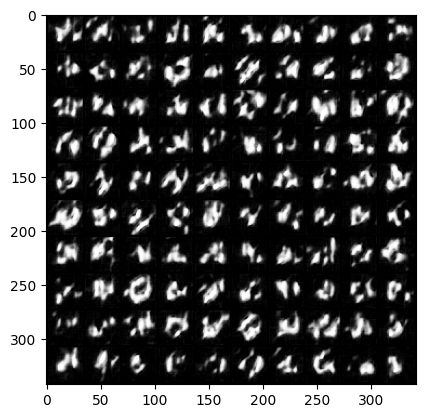


Epoch 2



Epoch 3



Epoch 4



Epoch 5



Epoch 6


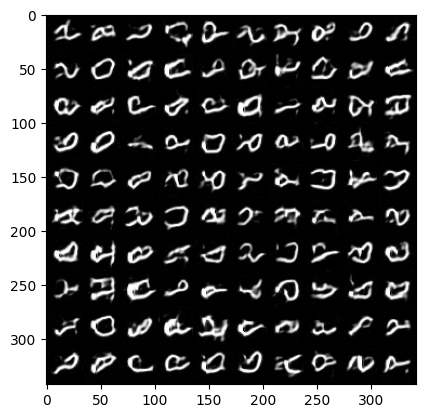


Epoch 7



Epoch 8



Epoch 9



Epoch 10



Epoch 11


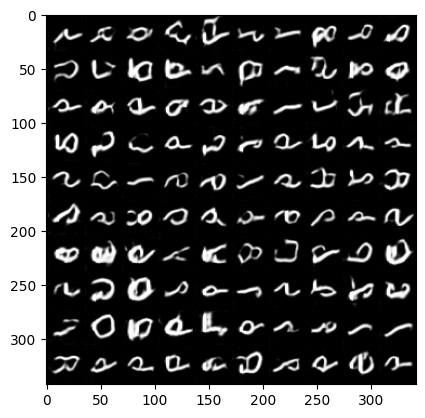


Epoch 12



Epoch 13



Epoch 14



Epoch 15



Epoch 16


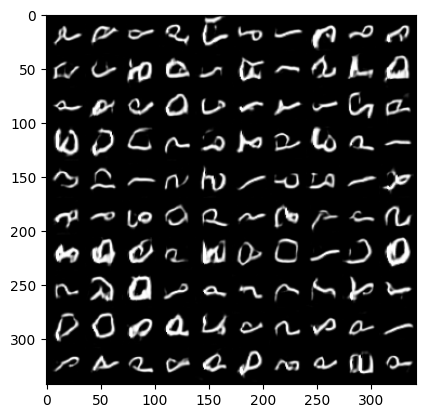


Epoch 17



Epoch 18



Epoch 19



Epoch 20



Epoch 21


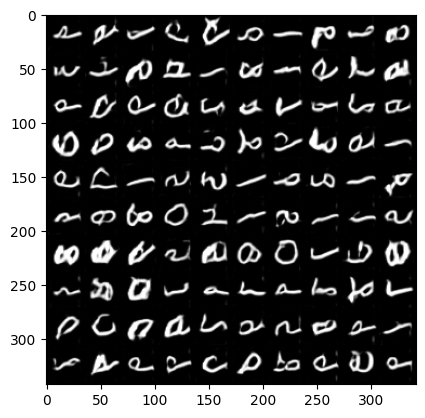


Epoch 22



Epoch 23



Epoch 24



Epoch 25



Epoch 26


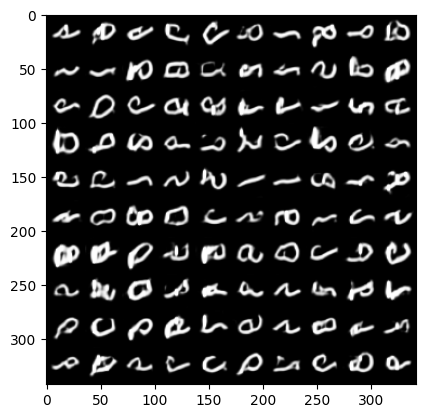


Epoch 27



Epoch 28



Epoch 29



Epoch 30



Epoch 31


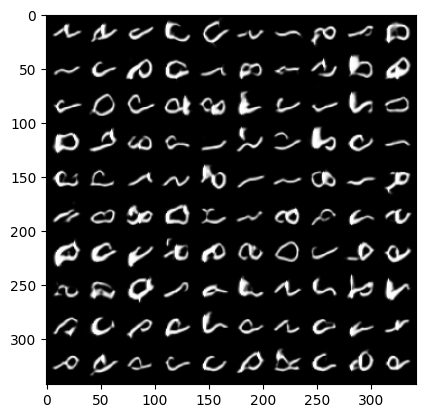


Epoch 32



Epoch 33



Epoch 34



Epoch 35



Epoch 36


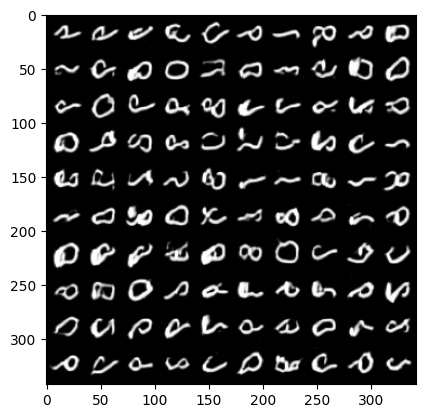


Epoch 37



Epoch 38



Epoch 39



Epoch 40



Epoch 41


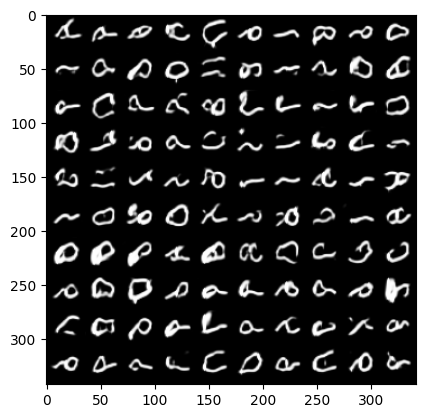


Epoch 42



Epoch 43



Epoch 44



Epoch 45



Epoch 46


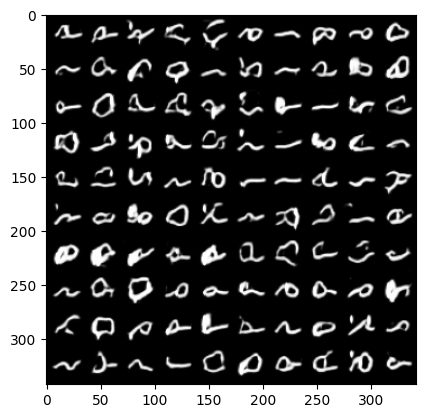


Epoch 47



Epoch 48



Epoch 49



Epoch 50


In [7]:
import torch
import torch.optim as optim

data_loader, _ = get_mnist_dataloaders(batch_size=2)
img_size = (32, 32, 1)
log_interval=5
generator = Generator(resnet = True, z_size = 128, channel = 1)
discriminator = Discriminator(resnet = True, spectral_normed = True, num_rotation = 4,
				 channel = 1, ssup = True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
discriminator=discriminator.to(device)
generator=generator.to(device)
# Initialize optimizers
lr = 1e-4
betas = (.9, .99)
G_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=betas)
D_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

# Train model
epochs = 50
trainer = Trainer(generator, discriminator, G_optimizer, D_optimizer,
                  weight_rotation_loss_d = 1.0, weight_rotation_loss_g = 0.5,
                  use_cuda=torch.cuda.is_available())
trainer.train(data_loader, epochs, save_training_gif=True)

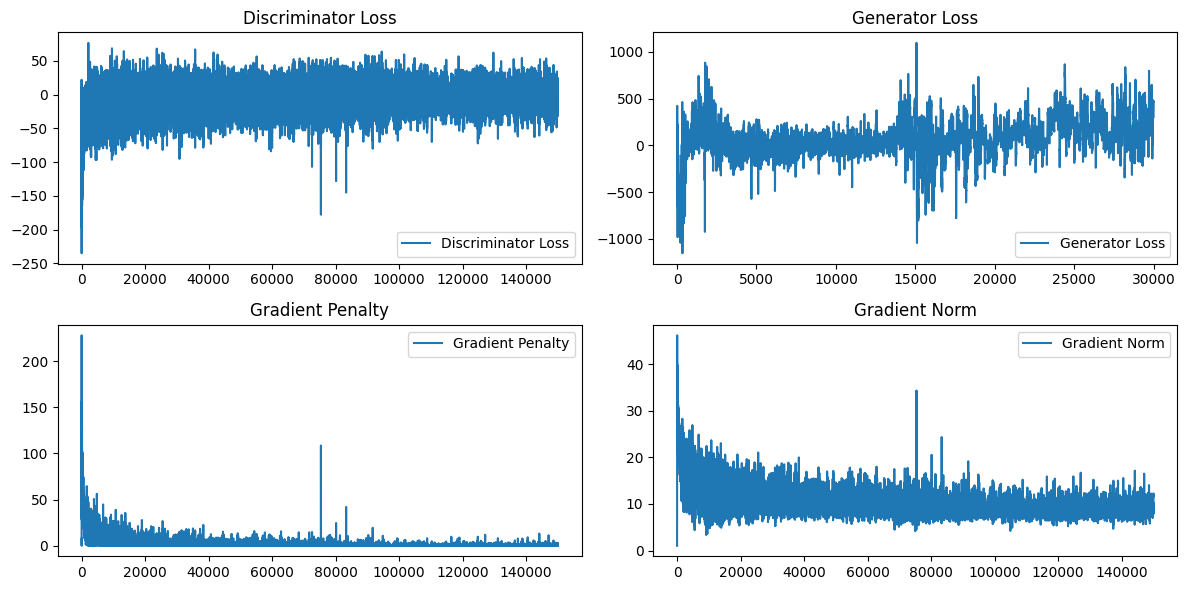

In [8]:

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
losses_D = [loss.cpu() for loss in trainer.losses['D']]
plt.plot(losses_D, label='Discriminator Loss')
plt.legend()
plt.title('Discriminator Loss')


plt.subplot(2, 2, 2)
losses_G = [loss.cpu() for loss in trainer.losses['G']]
plt.plot(losses_G, label='Generator Loss')
plt.legend()
plt.title('Generator Loss')

plt.subplot(2, 2, 3)
losses_GP = [loss.cpu() for loss in trainer.losses['GP']]
plt.plot(losses_GP, label='Gradient Penalty')
plt.legend()
plt.title('Gradient Penalty')

plt.subplot(2, 2, 4)
losses_gn = [loss.cpu() for loss in trainer.losses['gradient_norm']]
plt.plot(losses_gn, label='Gradient Norm')
plt.legend()
plt.title('Gradient Norm')

plt.tight_layout()
plt.show()

In [9]:
!rm -r "generated_images"
!rm -r "real_images"

In [11]:
from pytorch_fid import fid_score
import torchvision
import os


generated_images_path="generated_images"
real_images_path="real_images"
os.makedirs(generated_images_path, exist_ok=True)
os.makedirs(real_images_path, exist_ok=True)
latent_dim=128
with torch.no_grad():
    random_samples = generator(torch.randn(128, latent_dim).to(device))

for i, sample in enumerate(random_samples):
    torchvision.utils.save_image(sample, f'{generated_images_path}/generated_image_{i + 1}.png')

real_images = []
num_real_images_to_save=128

real_images=[]
for lables,images in data_loader:
    real_images.extend(lables)
    if len(real_images) >= num_real_images_to_save:
        break

# Save the real images using torchvision.utils.save_image
for i, real_sample in enumerate(real_images[:num_real_images_to_save]):
    torchvision.utils.save_image(real_sample, f'{real_images_path}/real_image_{i + 1}.png')

fid=fid_score.calculate_fid_given_paths([real_images_path, generated_images_path], batch_size=128, device=device, dims=2048)
print(f"The Fid score is: {fid}")

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 329MB/s]
100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


The Fid score is: 76.43398601412039
